In [11]:
import importlib, api_call
importlib.reload(api_call)
import pandas as pd
from data_loading import build_cap_dataset
from main import judges_promoted_from_district
from helper_functions import norm_id
from helper_functions import plot_distributions
from api_call import _extract_text
from api_call import load_case_results
import json
import seaborn as sns

In [ ]:
promoted        = pd.read_csv('results/promoted_judge_stats.csv')
judges          = pd.read_csv('data/judge_info.csv')
with open("results/appellate_matches.json", "r", encoding="utf-8") as f:
    app_matches = json.load(f)   
df = build_cap_dataset()

Working dir: /Users/ilyadavidson/Stanford_Internship/judge_project
Found 28 parquet files for pattern: data/parquet_files/CAP_data_*.parquet


In [9]:
len(df[df['is_appellate']==1])

51339

In [56]:
df[df['is_appellate']==1].sample(1)

,name,docket_number,decision_date,court_name,jurisdiction,cite,cites_to,judges_raw,judges_clean,judges_ids,opinion_type,opinion_author_raw,opinion_author_clean,opinion_author_id,opinion_text,unique_id,is_appellate
72407,"UNITED STATES of America v. Samuel WATSON, App...",No. 05-3892,2007-04-05,United States Court of Appeals for the Third C...,U.S.,482 Federal Reporter 3d Series 269,"83 Federal Reporter 3d Series 98, 451 Federal ...","Before FUENTES, VAN ANTWERPEN, and SILER , Cir...","[fuentes, van antwerpen]","[2855, 2437]",majority,"VAN ANTWERPEN, Circuit Judge.",van antwerpen,2437.0,"VAN ANTWERPEN, Circuit Judge.\nA federal grand...",72407,1


In [32]:
appellate_ids = df[df['is_appellate'] == 1]['unique_id'].astype(str)
matched = appellate_ids.isin(app_matches.keys()).sum()
print(matched) 

5818


In [34]:
print(f"There are {len(judges['judge id'].unique())} total judges.") # total number of judges in dataset

aj = judges[judges['court type'].str.contains('Appeals|Circuit', case=False, na=False)]

print(f"There are {len(aj['judge id'].unique())} appellate judges") # unique appellate judges

dj = judges[judges['court type'].str.contains('District')]

print(f"There are {len(dj['judge id'].unique())} district judges") # unique district judges

There are 4026 total judges.
There are 882 appellate judges
There are 3277 district judges


In [35]:
def promotion_info_judges(judge_info):
    """
    Returns a df of all judges who got promoted from district to appellate courts. Their promotion date is the earliest nomination date that they got to the appellate court. 
    """
    ji = judge_info.copy()
    ji['promotion date'] = pd.NaT

    aj = ji[ji['court type'].str.contains('Appeals|Circuit', case=False, na=False)]
    dj = ji[ji['court type'].str.contains('District')]
    pj = dj[dj['judge id'].isin(aj['judge id'])].copy()
    pj['nomination date'] = pd.to_datetime(pj['nomination date'], errors='coerce')
    pj = pj.sort_values(['judge id','nomination date']).drop_duplicates('judge id', keep='first')

    ji['is promoted'] = ji['judge id'].isin(pj['judge id']).astype(int)
    ji['promotion date'] = ji.apply(lambda row: pj[pj['judge id']==row['judge id']]['nomination date'].values[0] if row['is promoted'] else pd.NaT, axis=1)
    ji_district = ji[ji['court type'].str.contains('District')]
    ji_district = ji_district.drop_duplicates('judge id', keep='first')
    return ji_district

In [58]:
dsct_jdges = promotion_info_judges(judges) # judges with promotion info
len(dsct_jdges)

3277

In [59]:
dsct_jdges.sample(1)

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,ayes/nays,confirmation date,commission date,school 1,degree 1,school 2,degree 2,professional career,promotion date,is promoted
1139,744,fenner,Gary,Male,White,1947,St. Joseph,MO,NaN,,...,,1996-07-10,1996-07-25,University of Kansas,B.A.,University of Missouri-Kansas City School of Law,J.D.,"Private practice, Platte City, Missouri, 1973;...",NaT,0


In [38]:
len(dsct_jdges[dsct_jdges['is promoted']==1]) / len(dsct_jdges) * 100 # proportion of district judges who got promoted

9.826060421116875

In [39]:
len(dsct_jdges[(dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")) & (dsct_jdges['is promoted']==1)]) / len(dsct_jdges[dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")]) * 100 # proportion of district judges in the third court who got promoted

11.411411411411411

In [64]:
len(dsct_jdges[(dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")) & (dsct_jdges['is promoted']==1)])

38

In [63]:
thrd_judges = dsct_jdges[dsct_jdges['court name'].str.contains(r"Third|Delaware|New Jersey|Pennsylvania|Virgin Islands")]

In [65]:
def compute_district_overturns(
    df:             pd.DataFrame,
    dsct_judges:     pd.DataFrame, # district judges with promotion info
    api_path:       str = "batch_runs/api_responses.jsonl",
    mapping_path:   str = "results/appellate_matches.json",
) -> pd.DataFrame:
    """
    Computes district-level overturn rates for judges promoted from district to appellate courts.
    Returns a subset of `judge_info` with added columns for the overturn rates of promoted appellate judges.
    """

    # Initialization
    # List per judge what cases they've done, so we can iterrate over the cases and see which ones got overturned
    ####################################################################################################################
    pj                     = dsct_judges.copy()
    dsc                    = df[df['is_appellate']==0].copy()
    dsc["_author_id_norm"] = dsc["opinion_author_id"].map(norm_id)

    by_judge_cases = (
        dsc
        .dropna(subset=["_author_id_norm"])
        .groupby("_author_id_norm")
        .apply(lambda g: list(g.index))
        .to_dict()
    )

    pj["_judge_id_norm"]        = pj["judge id"].map(norm_id)
    pj["district_cases_list"]   = pj["_judge_id_norm"].map(by_judge_cases).apply(lambda x: x if isinstance(x, list) else [])
    pj["district cases"]        = pj["district_cases_list"].str.len().astype(int)

    # Load the appellate to district mapping and check which appellate cases were overturned
    ####################################################################################################################
    with open(mapping_path, "r", encoding="utf-8") as f:
        app_to_dct = json.load(f)

    # API info
    overturned_district_indices = set()
    with open(api_path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip(): 
                continue
            rec = json.loads(line)
            if rec.get("error"):
                continue
            txt = _extract_text(rec.get("response", {}))
            if not txt:
                continue
            try:
                obj = json.loads(txt)  # 9-key JSON from model
            except json.JSONDecodeError:
                continue
            opinion = obj.get("opinion")
            if opinion is None:
                continue
            if opinion != "affirmed":
                app_id = str(rec.get("custom_id"))
                if app_id in app_to_dct:
                    try:
                        overturned_district_indices.add(int(app_to_dct[app_id]))
                    except Exception:
                        # ignore non-integer district indices
                        pass

    # Get the number of appeals per judge
    # Collect the set of district cases that were appealed
    appealed_district_cases = set(app_to_dct.values())

    # Count how many of a judge’s district cases are in that set
    pj["appealed cases"] = pj["district_cases_list"].apply(
        lambda case_list: sum(1 for cid in case_list if cid in appealed_district_cases)
    ).astype(int)

    # Get the overturn counts per judge
    ####################################################################################################################
    def _count_overturned(case_list):
        if not case_list:
            return 0
        return sum(1 for cid in case_list if cid in overturned_district_indices)

    pj["district_cases_overturned"]         = pj["district_cases_list"].apply(_count_overturned).astype(int)
    pj["district_overturn_rate"]            = pj.apply(
        lambda r: (r["district_cases_overturned"] / r["district cases"]) if r["district cases"] else pd.NA,
        axis=1
    )
    pj.drop(columns=["_judge_id_norm"], inplace=True)

    return pj

In [66]:
overturns = compute_district_overturns(df, thrd_judges)

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_79829/2553365184.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: list(g.index))


In [67]:
overturns.sample(3)

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,school 2,degree 2,professional career,promotion date,is promoted,district_cases_list,district cases,appealed cases,district_cases_overturned,district_overturn_rate
110,71,augelli,Anthony,Male,White,1902,Orsara,Italy,1985.0,Spring Lake Heights,...,Mercer Beasley School of Law (now Rutgers Scho...,LL.M.,"Private practice, Jersey City, New Jersey, 193...",NaT,0,"[17063, 17138, 17168, 17217, 17224, 17233, 172...",54,13,7,0.12963
3999,2671,yohn,William,Male,White,1935,Pottstown,PA,NaN,,...,Princeton University,B.A.,"U.S. Marine Corps Reserve, 1960-1965; active d...",NaT,0,"[3746, 3863, 4014, 4305, 4939, 5244, 7928, 327...",123,10,4,0.03252
2965,6731086,ranjan,J.,Male,Asian American,1978,Lancaster,OH,NaN,NaN,...,University of Michigan Law School,J.D.,"Simon Karas Fellow, Office of the State Solici...",NaT,0,[],0,0,0,<NA>


In [68]:
bt10 = overturns[overturns['district cases']>=30]

In [69]:
bt10[bt10['is promoted']==0]['district_overturn_rate'].mean()

np.float64(0.0396323600053434)

In [70]:
bt10.groupby("is promoted")["district cases"].mean()

is promoted
0    197.581152
1    179.730769
Name: district cases, dtype: float64

In [71]:
bt10.groupby("is promoted")["district_overturn_rate"].mean()

is promoted
0    0.039632
1    0.035496
Name: district_overturn_rate, dtype: object

In [72]:
promoted_mean = bt10[bt10["is promoted"] == 1]["district_overturn_rate"].mean()
not_promoted_mean = bt10[bt10["is promoted"] == 0]["district_overturn_rate"].mean()
effect = promoted_mean - not_promoted_mean
print("Average effect of being promoted:", effect)

Average effect of being promoted: -0.004136638046960316


In [73]:
import statsmodels.api as sm

# Predictor and outcome
bt10["high_overturn"] = (bt10["district_overturn_rate"] > 0.039).astype(int) # the average
X = bt10["is promoted"].astype(float)
X = sm.add_constant(X)  # add intercept
y = bt10["high_overturn"]

# Logistic regression
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.678558
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          high_overturn   No. Observations:                  217
Model:                          Logit   Df Residuals:                      215
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Sep 2025   Pseudo R-squ.:                0.002242
Time:                        18:16:24   Log-Likelihood:                -147.25
converged:                       True   LL-Null:                       -147.58
Covariance Type:            nonrobust   LLR p-value:                    0.4160
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2846      0.146     -1.947      0.052      -0.571       0.002
is promoted    -0.3514    

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_79829/3059813203.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["high_overturn"] = (bt10["district_overturn_rate"] > 0.039).astype(int) # the average


In [80]:
case_results = load_case_results()
case_results.sample(1)

,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level,lower_judge_first,lower_judge_last,custom_id
6790,affirmed,civil,insufficient evidence,other,other,1.0,low,None,None,53459


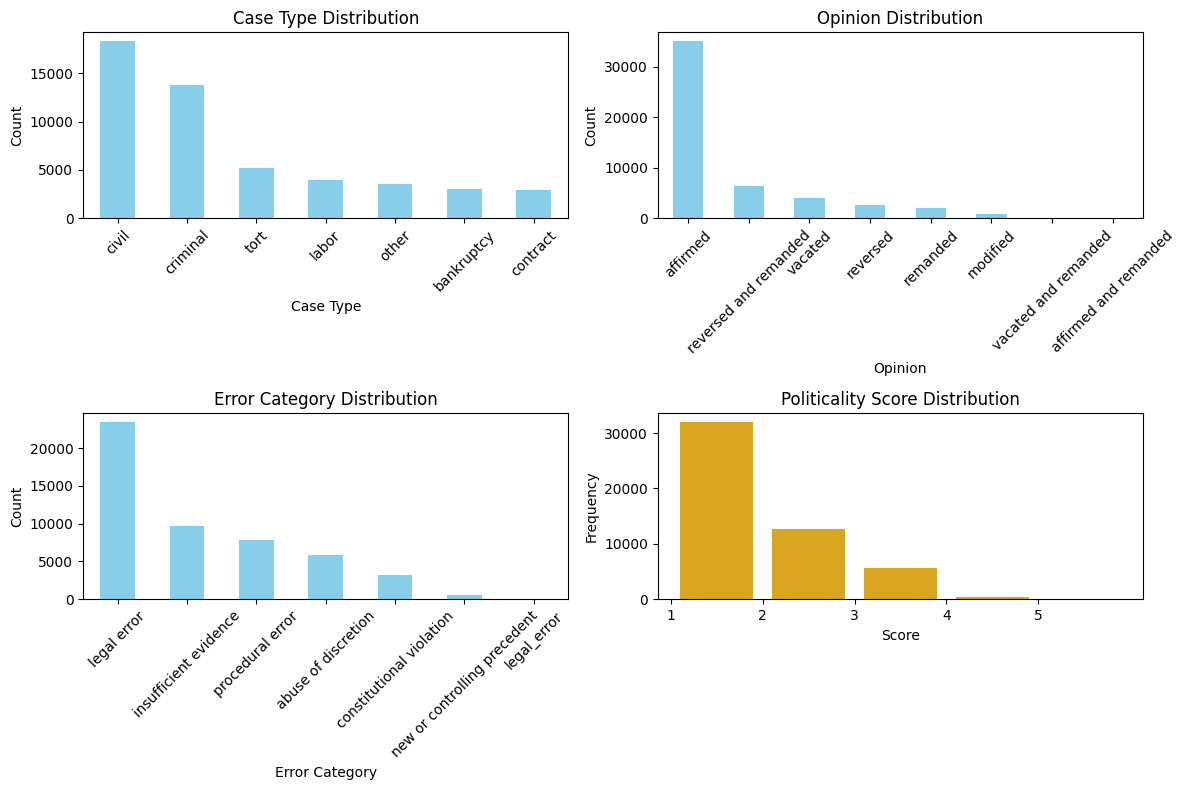

In [81]:
plot_distributions(case_results, ["case_type", "opinion", "error_category", "politicality_score"])

In [558]:
case_results.groupby('case_type').apply(
    lambda group: len(group[group['opinion'] == 'affirmed']) / len(group) * 100
)

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_68266/2251497098.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  case_results.groupby('case_type').apply(


case_type
bankruptcy    62.866450
civil         66.695828
contract      59.271978
criminal      75.139726
labor         57.838389
other         82.829978
tort          60.686728
dtype: float64

In [ ]:
len(case_results[case_results['opinion']=='affirmed']) / len(case_results) * 100

68.16137385852528

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_79829/1331619923.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["appealed cases"] = bt10["appealed cases"].astype(int)
/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_79829/1331619923.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["district_overturn_rate"] = bt10["district_overturn_rate"].astype(float)


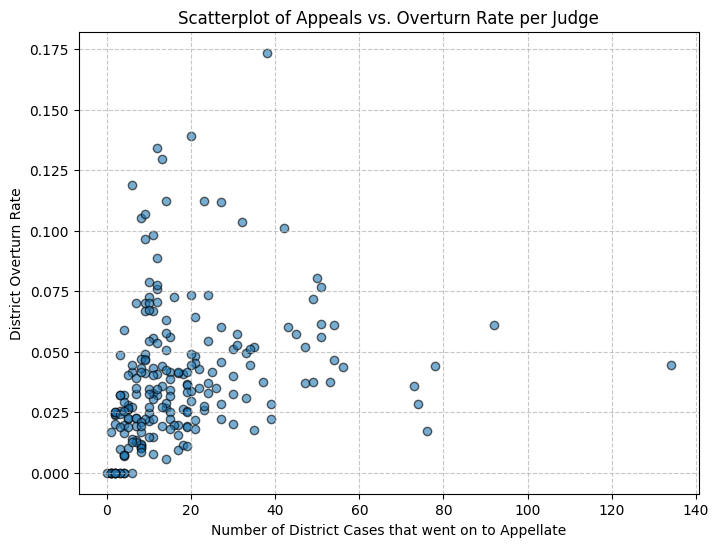

In [74]:
import matplotlib.pyplot as plt

# Example: use your DataFrame "bt10"
# Ensure numeric types
bt10["appealed cases"] = bt10["appealed cases"].astype(int)
bt10["district_overturn_rate"] = bt10["district_overturn_rate"].astype(float)

plt.figure(figsize=(8,6))
plt.scatter(
    bt10["appealed cases"], 
    bt10["district_overturn_rate"], 
    alpha=0.6, edgecolor="k"
)

plt.xlabel("Number of District Cases that went on to Appellate")
plt.ylabel("District Overturn Rate")
plt.title("Scatterplot of Appeals vs. Overturn Rate per Judge")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

In [570]:
import json
import numpy as np
import pandas as pd
from scipy.stats import chi2

# Inputs you already have:
# df: cases DataFrame with index = district case id; columns include is_appellate, opinion_author_id
# pj: judges DataFrame with "judge id" and a column "district_cases_list" (list of district case ids per judge)
# mapping_path: JSON mapping {<appellate_id>: <district_index>}

mapping_path = "results/appellate_matches.json"

# 1) Build the set of *district* case ids that were appealed
with open(mapping_path, "r", encoding="utf-8") as f:
    app_to_dct = json.load(f)

appealed_district_ids = set()
for k, v in app_to_dct.items():
    try:
        appealed_district_ids.add(int(v))
    except Exception:
        continue

# 2) Per judge: count how many of their district cases were appealed (regardless of outcome)
def count_appealed(case_list):
    if not isinstance(case_list, (list, tuple)):
        return 0
    return sum(1 for cid in case_list if cid in appealed_district_ids)

pj = bt10.copy()
pj["appealed_cases"] = pj["appealed cases"]

# 3) Quick dispersion view: mean/median/std/CV and a few quantiles
summary = pj["appealed_cases"].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95])
cv = (pj["appealed_cases"].std(ddof=1) / max(summary["mean"], 1e-9))
print("Appealed cases per judge — summary stats")
print(summary)
print(f"Coefficient of Variation (std/mean): {cv:.3f}")

# (Optional) peek at a few extremes
print("\nTop 10 judges by appealed cases:")
print(pj[["judge id","appealed_cases","district cases"]].sort_values("appealed_cases", ascending=False).head(10))

print("\nBottom 10 judges by appealed cases (with at least 1 district case):")
print(pj[pj["district cases"]>0][["judge id","appealed_cases","district cases"]]
      .sort_values("appealed_cases", ascending=True).head(10))

# 4) Are judges getting “about the same” number appealed given exposure?
#    Test: assume a common appeal probability p across judges; compare observed vs expected with Pearson χ².
#    Only include judges with at least 1 district case to avoid division issues.
g = pj[pj["district cases"] > 0].copy()
n = g["district cases"].to_numpy(dtype=float)       # exposures (trials)
obs = g["appealed_cases"].to_numpy(dtype=float)

# Global appeal rate p-hat:
p_hat = obs.sum() / n.sum() if n.sum() > 0 else np.nan
exp = n * p_hat

# Filter out judges whose expected count is ~0 (no power there)
mask = exp > 0
obs2 = obs[mask]
exp2 = exp[mask]
k = obs2.size

if k >= 2 and np.isfinite(p_hat):
    chi2_stat = ((obs2 - exp2)**2 / exp2).sum()
    # degrees of freedom ~ (k - 1) because we estimated a single parameter p_hat
    df_ = max(k - 1, 1)
    p_value = 1 - chi2.cdf(chi2_stat, df_)
    print("\nGoodness-of-fit to a single common appeal rate (binomial with exposure):")
    print(f"- p_hat (overall appeal rate): {p_hat:.4f}")
    print(f"- Pearson χ²: {chi2_stat:.2f} on {df_} df  ->  p = {p_value:.4g}")
    if p_value < 0.05:
        print("⇒ Variation across judges is larger than expected if all shared the same appeal rate.")
    else:
        print("⇒ No strong evidence of heterogeneity; appealed counts look consistent with a common rate.")
else:
    print("\nNot enough data to run the goodness-of-fit test (check exposures).")

# 5) (Optional) Standardized residuals per judge to see who’s high/low relative to exposure
if k >= 2 and np.isfinite(p_hat):
    # Avoid division by zero
    denom = np.sqrt(np.maximum(exp, 1e-12))
    g["std_resid"] = (obs - exp) / denom
    print("\nJudges with largest positive residuals (more appeals than expected given exposure):")
    print(g[["judge id","appealed_cases","district cases","std_resid"]]
          .sort_values("std_resid", ascending=False).head(10))
    print("\nJudges with most negative residuals (fewer appeals than expected):")
    print(g[["judge id","appealed_cases","district cases","std_resid"]]
          .sort_values("std_resid", ascending=True).head(10))

Appealed cases per judge — summary stats
count    197.000000
mean      19.137056
std       18.051697
min        0.000000
10%        4.000000
25%        8.000000
50%       14.000000
75%       23.000000
90%       42.400000
95%       51.400000
max      134.000000
Name: appealed_cases, dtype: float64
Coefficient of Variation (std/mean): 0.943

Top 10 judges by appealed cases:
      judge id  appealed_cases  district cases
1969      1287             134             629
1370       896              92             624
950        616              78             590
3071      2032              76            1112
2267      1484              74             529
2424      1597              73             749
3802      2527              56             709
1184       773              54             388
2678      1763              54             245
3208      2118              53             347

Bottom 10 judges by appealed cases (with at least 1 district case):
      judge id  appealed_cases  distric

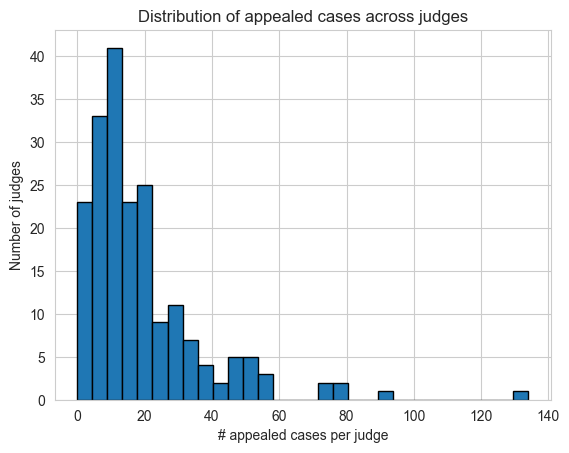

In [571]:
import matplotlib.pyplot as plt

plt.hist(pj["appealed_cases"], bins=30, edgecolor="black")
plt.xlabel("# appealed cases per judge")
plt.ylabel("Number of judges")
plt.title("Distribution of appealed cases across judges")
plt.show()

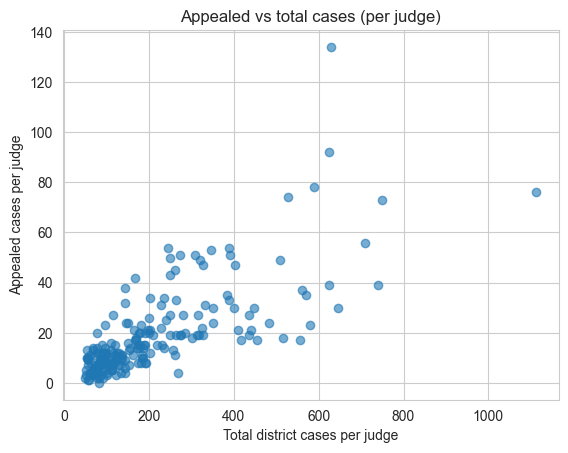

In [572]:
plt.scatter(pj["district cases"], pj["appealed_cases"], alpha=0.6)
plt.xlabel("Total district cases per judge")
plt.ylabel("Appealed cases per judge")
plt.title("Appealed vs total cases (per judge)")
plt.show()